<a href="https://colab.research.google.com/github/mohitDhami87/Uber_Ride_Completion_in_NCR_Bookings_CaseStudy/blob/main/Uber_Ride_Completion_in_NCR_Bookings_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uber Ride Completion in NCR Bookings


---



The primary goal is to build a high-accuracy predictive model to estimate the probability that a
ride request, once accepted, will be successfully Completed. This prediction is vital for reducing
driver churn (by minimizing fruitless pickups), managing customer expectation (by reducing
estimated time of arrival (ETA) uncertainty), and proactively implementing dynamic
interventions (e.g., penalty adjustments, pre-emptive re-dispatch) to improve the platform's
reliability.

In [2]:
# Gdrive dataset link
# https://drive.google.com/file/d/16Z63yn4vlbu7iisf4r70vfKcViu568uP/view?usp=sharing

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
dataset_url_path = "https://drive.google.com/uc?export=download&id=16Z63yn4vlbu7iisf4r70vfKcViu568uP"
df  = pd.read_csv(dataset_url_path)
df.head()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

In [8]:
df.describe()

,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Cancelled Rides by Driver,Incomplete Rides,Booking Value,Ride Distance,Driver Ratings,Customer Rating
count,139500.000000,102000.000000,10500.0,27000.0,9000.0,102000.000000,102000.000000,93000.000000,93000.000000
mean,8.456352,29.149636,1.0,1.0,1.0,508.295912,24.637012,4.230992,4.404584
std,3.773564,8.902577,0.0,0.0,0.0,395.805774,14.002138,0.436871,0.437819
min,2.000000,10.000000,1.0,1.0,1.0,50.000000,1.000000,3.000000,3.000000
25%,5.300000,21.600000,1.0,1.0,1.0,234.000000,12.460000,4.100000,4.200000
50%,8.300000,28.800000,1.0,1.0,1.0,414.000000,23.720000,4.300000,4.500000
75%,11.300000,36.800000,1.0,1.0,1.0,689.000000,36.820000,4.600000,4.800000
max,20.000000,45.000000,1.0,1.0,1.0,4277.000000,50.000000,5.000000,5.000000


In [10]:
df.isnull().all()

,0
Date,False
Time,False
Booking ID,False
Booking Status,False
Customer ID,False
Vehicle Type,False
Pickup Location,False
Drop Location,False
Avg VTAT,False
Avg CTAT,False


In [23]:
df.isna().sum()

,0
Date,0
Time,0
Booking ID,0
Booking Status,0
Customer ID,0
Vehicle Type,0
Pickup Location,0
Drop Location,0
Avg VTAT,10500
Avg CTAT,48000


In [25]:
df.duplicated().sum()

np.int64(0)

In [11]:
# Checking shape of dataframe
print(f'Number of rows in training dataset: {df.shape[0]}')
print(f'Number of columns in training dataset: {df.shape[1]}')

Number of rows in training dataset: 150000
Number of columns in training dataset: 21


In [12]:
categorical_cols = df.select_dtypes(include='object').columns
categorical_cols

Index(['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID',
       'Vehicle Type', 'Pickup Location', 'Drop Location',
       'Reason for cancelling by Customer', 'Driver Cancellation Reason',
       'Incomplete Rides Reason', 'Payment Method'],
      dtype='object')

In [13]:
def classify_columns(data):
    # Initialize lists for categorical and numerical columns
    cat_col = []
    num_col = []

    # Iterate through columns in the DataFrame
    for column in data.columns:
        # Count the number of unique values in the column
        unique_values = data[column].nunique()

        # If there are fewer than 3 unique values, consider it a categorical column
        if unique_values < 3:
            cat_col.append(column)
        # Otherwise, consider it a numerical column
        else:
            num_col.append(column)

    # Return the lists of categorical and numerical columns
    return cat_col, num_col


In [14]:
cat_col, num_col = classify_columns(df)
print(f'Categorical columns in training dataset: {cat_col}')
print(f'Numerical columns in training dataset: {num_col}')

Categorical columns in training dataset: ['Cancelled Rides by Customer', 'Cancelled Rides by Driver', 'Incomplete Rides']
Numerical columns in training dataset: ['Date', 'Time', 'Booking ID', 'Booking Status', 'Customer ID', 'Vehicle Type', 'Pickup Location', 'Drop Location', 'Avg VTAT', 'Avg CTAT', 'Reason for cancelling by Customer', 'Driver Cancellation Reason', 'Incomplete Rides Reason', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating', 'Payment Method']


In [26]:
pre_col = ['Avg VTAT','Avg CTAT']
for col in pre_col:
  print(df[col].describe())
  print('*'*40)

count    139500.000000
mean          8.456352
std           3.773564
min           2.000000
25%           5.300000
50%           8.300000
75%          11.300000
max          20.000000
Name: Avg VTAT, dtype: float64
****************************************
count    102000.000000
mean         29.149636
std           8.902577
min          10.000000
25%          21.600000
50%          28.800000
75%          36.800000
max          45.000000
Name: Avg CTAT, dtype: float64
****************************************


In [29]:
pre_col = ['Avg VTAT','Avg CTAT']
for col in pre_col:
  df[col]=df[col].fillna(df[col].mean())
  print(df[col])


0          8.3
1          4.9
2         13.4
3         13.1
4          5.3
          ... 
149995    10.2
149996     5.1
149997     2.7
149998     6.9
149999     3.5
Name: Avg VTAT, Length: 150000, dtype: float64
0         28.8
1         14.0
2         25.8
3         28.5
4         19.6
          ... 
149995    44.4
149996    30.8
149997    23.4
149998    39.6
149999    33.7
Name: Avg CTAT, Length: 150000, dtype: float64


In [30]:
df.head(2)

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,8.3,28.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI


In [34]:
df['Cancelled Rides by Driver'].isna().any()

np.True_

In [35]:
pre_cols=['Cancelled Rides by Customer','Cancelled Rides by Driver']
for col in pre_cols:
  df[col]=df[col].fillna(0)
df['Cancelled Rides by Customer']=df['Cancelled Rides by Customer'].replace("nul",0)

In [36]:
df.head(2)

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,8.3,28.8,...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,0.0,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI


In [37]:
pre_cols=['Cancelled Rides by Customer','Cancelled Rides by Driver']
for col in pre_cols:
  df[col] = df[col].astype(int).map({1: 'Cancelled', 0: 'Not Cancelled'})
  print(df[col].value_counts())
  print('*'*50)

Cancelled Rides by Customer
Not Cancelled    139500
Cancelled         10500
Name: count, dtype: int64
**************************************************
Cancelled Rides by Driver
Not Cancelled    123000
Cancelled         27000
Name: count, dtype: int64
**************************************************


In [38]:
pre_cols=['Reason for cancelling by Customer','Driver Cancellation Reason','Incomplete Rides Reason']
for col in pre_cols:
  df[col]=df[col].fillna('Empty Filled')
  print(df[col].value_counts())
  print('*'*50)

Reason for cancelling by Customer
Empty Filled                                    139500
Wrong Address                                     2362
Change of plans                                   2353
Driver is not moving towards pickup location      2335
Driver asked to cancel                            2295
AC is not working                                 1155
Name: count, dtype: int64
**************************************************
Driver Cancellation Reason
Empty Filled                           123000
Customer related issue                   6837
The customer was coughing/sick           6751
Personal & Car related issues            6726
More than permitted people in there      6686
Name: count, dtype: int64
**************************************************
Incomplete Rides Reason
Empty Filled         141000
Customer Demand        3040
Vehicle Breakdown      3012
Other Issue            2948
Name: count, dtype: int64
**************************************************


In [39]:
df['Incomplete Rides'] = df['Incomplete Rides'].fillna(0).astype(int).map({1: 'Incomplete', 0: 'complete'})
print(df['Incomplete Rides'].value_counts())

Incomplete Rides
complete      141000
Incomplete      9000
Name: count, dtype: int64


In [40]:
df['Booking Status'].value_counts()

,count
Booking Status,
Completed,93000
Cancelled by Driver,27000
No Driver Found,10500
Cancelled by Customer,10500
Incomplete,9000


In [41]:
# Completed Rides
mask_completed = df['Booking Status'] == 'Completed'
df.loc[mask_completed, 'Booking Value'] = df.loc[mask_completed, 'Booking Value'].fillna(df['Booking Value'].median())
df.loc[mask_completed, 'Ride Distance'] = df.loc[mask_completed, 'Ride Distance'].fillna(df['Ride Distance'].median())
df.loc[mask_completed, 'Driver Ratings'] = df.loc[mask_completed, 'Driver Ratings'].fillna(round(df['Driver Ratings'].mean(), 1))
df.loc[mask_completed, 'Customer Rating'] = df.loc[mask_completed, 'Customer Rating'].fillna(round(df['Customer Rating'].mean(), 1))
df.loc[mask_completed, 'Payment Method'] = df.loc[mask_completed, 'Payment Method'].fillna(df['Payment Method'].mode()[0])


In [42]:
# Cancelled Rides & Incomplete Rides
mask_cancelled_or_incomplete = df['Booking Status'].isin(['Cancelled by Customer','Cancelled by Driver','No Driver Found','Incomplete'])

df.loc[mask_cancelled_or_incomplete, ['Booking Value', 'Ride Distance']] = 0
df.loc[mask_cancelled_or_incomplete, ['Driver Ratings', 'Customer Rating']] = np.nan
df.loc[mask_cancelled_or_incomplete, 'Payment Method'] = 'Incomplete Ride'

In [43]:
df['Booking Status'].value_counts()


,count
Booking Status,
Completed,93000
Cancelled by Driver,27000
No Driver Found,10500
Cancelled by Customer,10500
Incomplete,9000


# Data Analysis

In [44]:
len(df['Booking ID'])

150000

In [45]:
status_dist=(df['Booking Status'].value_counts(normalize=True)*100).reset_index()
status_dist


,Booking Status,proportion
0,Completed,62.0
1,Cancelled by Driver,18.0
2,No Driver Found,7.0
3,Cancelled by Customer,7.0
4,Incomplete,6.0


In [46]:
vehicle_dist=(df['Vehicle Type'].value_counts(normalize=True)*100).reset_index()
vehicle_dist


,Vehicle Type,proportion
0,Auto,24.946000
1,Go Mini,19.870667
2,Go Sedan,18.094000
3,Bike,15.011333
4,Premier Sedan,12.074000
5,eBike,7.038000
6,Uber XL,2.966000


/tmp/ipython-input-1100811803.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
/tmp/ipython-input-1100811803.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


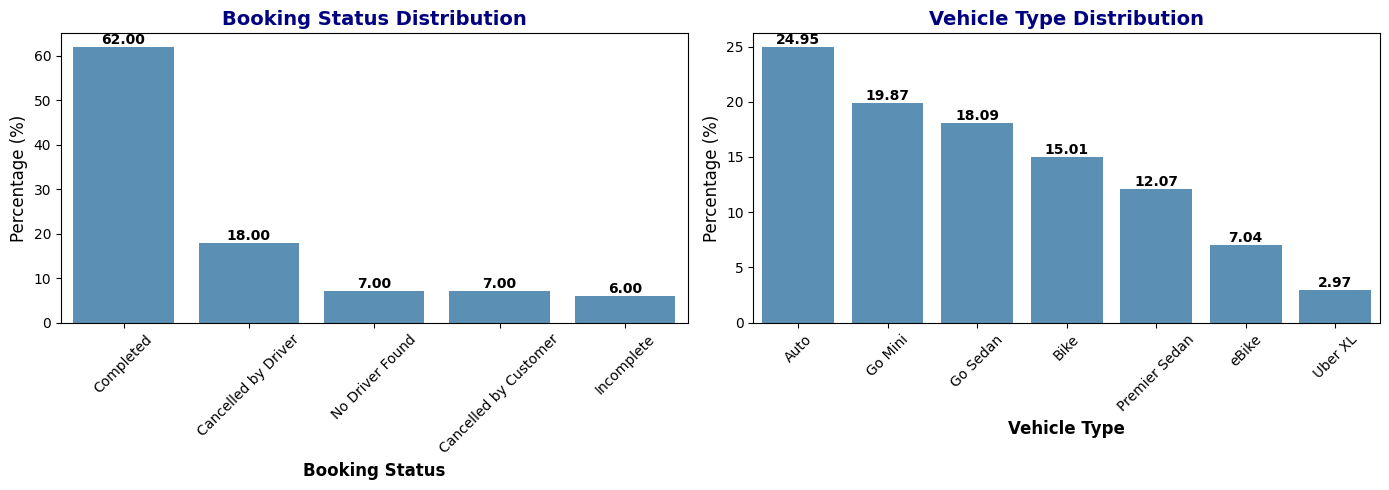

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.barplot(data=status_dist, x='Booking Status', y='proportion', alpha=0.8, ax=axes[0])
axes[0].set_xlabel("Booking Status", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Percentage (%)", fontsize=12)
axes[0].set_title("Booking Status Distribution", fontsize=14, fontweight='bold', color='navy')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)


for p in axes[0].patches:
    axes[0].annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='black'
    )


sns.barplot(data=vehicle_dist, x='Vehicle Type', y='proportion', alpha=0.8, ax=axes[1])
axes[1].set_xlabel("Vehicle Type", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Percentage (%)", fontsize=12)
axes[1].set_title("Vehicle Type Distribution", fontsize=14, fontweight='bold', color='navy')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


for p in axes[1].patches:
    axes[1].annotate(
        f'{p.get_height():.2f}',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom',
        fontsize=10, fontweight='bold', color='black'
    )

plt.tight_layout()
plt.show()

In [48]:
Pickup_Location_dist=(df['Pickup Location'].value_counts(normalize=True)*100).reset_index()
Pickup_Location_dist_top10=Pickup_Location_dist[:10]
Pickup_Location_dist_top10

,Pickup Location,proportion
0,Khandsa,0.632667
1,Barakhamba Road,0.630667
2,Saket,0.620667
3,Badarpur,0.614000
4,Pragati Maidan,0.613333
5,Madipur,0.612667
6,AIIMS,0.612000
7,Mehrauli,0.610000
8,Dwarka Sector 21,0.609333
9,Pataudi Chowk,0.604667


In [49]:
Drop_Location_dist=(df['Drop Location'].value_counts(normalize=True)*100).reset_index()
Drop_Location_dist_top=Drop_Location_dist[:10]
Drop_Location_dist_top

,Drop Location,proportion
0,Ashram,0.624000
1,Basai Dhankot,0.611333
2,Lok Kalyan Marg,0.610667
3,Narsinghpur,0.608667
4,Cyber Hub,0.608000
5,Kalkaji,0.608000
6,Kashmere Gate ISBT,0.606000
7,Udyog Vihar,0.604000
8,Lajpat Nagar,0.602667
9,Madipur,0.601333


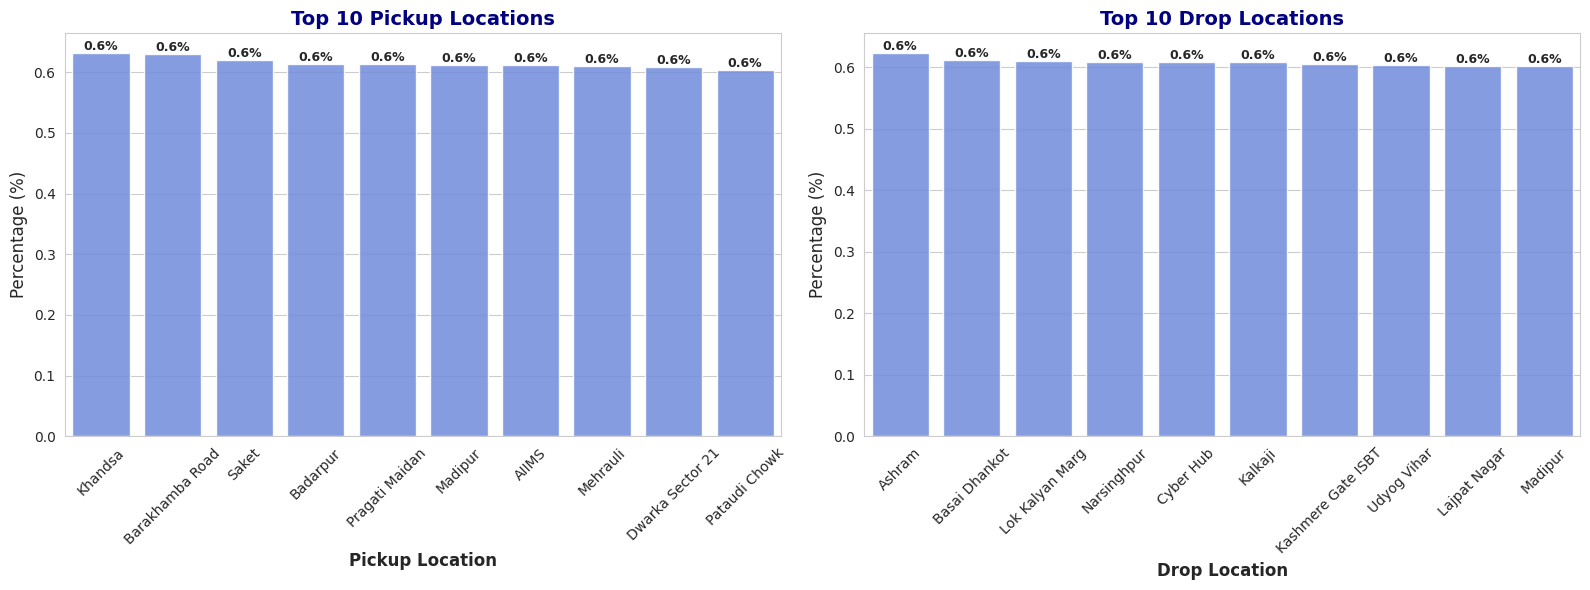

In [50]:
sns.set_style("whitegrid")
sns.set_palette("coolwarm")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=Pickup_Location_dist_top10,x='Pickup Location', y='proportion',ax=axes[0], alpha=0.9)
axes[0].set_title("Top 10 Pickup Locations", fontsize=14, fontweight='bold', color='navy')
axes[0].set_xlabel("Pickup Location", fontsize=12, fontweight='bold')
axes[0].set_ylabel("Percentage (%)", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)

for p in axes[0].patches:
    axes[0].annotate(
        f'{p.get_height():.1f}%',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom', fontsize=9, fontweight='bold'
    )


sns.barplot(
    data=Drop_Location_dist_top,
    x='Drop Location', y='proportion',
    ax=axes[1], alpha=0.9
)
axes[1].set_title("Top 10 Drop Locations", fontsize=14, fontweight='bold', color='navy')
axes[1].set_xlabel("Drop Location", fontsize=12, fontweight='bold')
axes[1].set_ylabel("Percentage (%)", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)

for p in axes[1].patches:
    axes[1].annotate(
        f'{p.get_height():.1f}%',
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center', va='bottom', fontsize=9, fontweight='bold'
    )

plt.tight_layout()
plt.show()
